# Voice Activity Detection in Noisy Environments

This is the notebook associated with the project work carried out by Nicklas Hansen (s153077) and Simon Albrechtsen (s134868) for course 02456 Deep Learning at Technical University of Denmark (DTU).

Execution has been tested on both Linux and Windows machines, but to avoid problems Linux is the recommended OS. Please read the folllowing instructions carefully for a quick setup.

# Datasets

This notebook can be ran in two different modes: either you download and pre-process all data from scratch (takes roughly 16 hours on a personal computer) or you download and execute with already processed data (27 GB).

In any case, you will want to create a local directory that can contain all necessary data and outputs. If you want to start from scratch, these are the two datasets that you need to collect:

#### LibriSpeech ASR corpus
Download the voice dataset `dev-clean.tar.gz` from http://www.openslr.org/12/ and extract in the directory you created for the data. Leave the file structure as it is.

#### QUT-NOISE
Download the entire noise dataset from https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/.
Extract all zip-files in the directory you created for the data. Leave the file structure as it is.

# Running the notebook

If you choose to run the notebook using already processed data, download the following `data.hdf5` file from our private cloud storage: https://1drv.ms/u/s!AnqePMbr4kj8lt8gI7CuaamxpUjPUA (expires 03/03/2019). The file should be placed in a `/data/` subfolder in your chosen local directory.

If you choose to train models yourself, you can do so after either downloading the data file or processing it yourself. If you do not wish to train models but want to execute the ones that we have prepared, make sure to download them from GitHub and place them in a `/models/` subfolder within your chosen directory. Alternatively, results from our own run can be viewed as-is without running anything yourself.

Further down this notebook, a number of *objectives* are defined. By flipping these booleans, you can control whether or not you want to prepare data and/or train models. For a fast run-through, it is recommended to download all necessary data and simply run the notebook with default settings.

# Set default directory
Define the default directory such that it points to the location of the locally stored data files.

As we are two students collaborating on this project, we automatically set the path according to who's currently running. This is achieved with `os.path.exists`.<br/>
If one wants to run this notebook, simply input a valid path to your data directory for `path_peer`.

In [1]:
path_peer = 'YOUR PATH GOES HERE'

We can then proceed to check which directory to use. If everything goes right, you will see your path echoed in the output.

In [2]:
import os
path_nicklas, path_simon = 'C:/Users/nickl/OneDrive/dp/retune/data', '/media/simonha/Storage/02456/data'
is_peer = os.path.exists(path_peer)
is_nicklas = os.path.exists(path_nicklas) if not is_peer else False
if is_peer:
    os.chdir(path_peer)
else:
    os.chdir(path_nicklas if is_nicklas else path_simon)
print('Directory is set to', os.getcwd())

Directory is set to C:\Users\nickl\OneDrive\dp\retune\data


# Install dependencies.
For converting the LibriSpeech data set from FLAC to WAV we will use `pydub`, which requires the `ffmpeg` library.

Follow the instructions on https://github.com/jiaaro/pydub#dependencies to set up `ffmpeg`.

We will install the other dependencies with `pip`.

In [4]:
!pip install SoundFile
!pip install webrtcvad
!pip install pydub
!pip install python_speech_features
!pip install h5py
!pip install h5py_cache

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider 

# Set up project settings

The settings seen below are considered global constants and should not be changed for the duration of the project.

In [3]:
# Specify the desired WAV-format.
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# Name of folder to save the data files in.
DATA_FOLDER = 'data'

# Min/max length for slicing the voice files.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Frame size to use for the labelling.
FRAME_SIZE_MS = 30

# Convert slice ms to frame size.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

# Calculate frame size in data points.
FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))

# Set up objectives for current run

A number of global parameters that serve to customize the run-through.

`OBJ_SHOW_PLAYABLE_TRACKS` should be disabled on Windows machines.<br/>
`OBJ_PREPARE_AUDIO` should always be false unless one wants to force a new data generation.<br/>
`OBJ_TRAIN_MODELS` will enforce a fresh training of our defined models, rather than loading them from local storage.<br/>
`OBJ_CUDA` denotes whether CUDA is available for GPU-acceleration.

In [4]:
import torch

OBJ_SHOW_PLAYABLE_TRACKS = not is_nicklas
OBJ_CUDA = torch.cuda.is_available()

OBJ_PREPARE_AUDIO = False
OBJ_TRAIN_MODELS = False

if OBJ_CUDA:
    print('CUDA has been enabled.')
else:
    print('CUDA has been disabled.')

CUDA has been enabled.


# Prepare the audio files
Some of the audio files are stored in a FLAC-format. The others are in WAV-format. The format differs for each dataset, so we have defined a class to help us unify the data.

We convert the FLAC-files into WAV-files such that we have a raw format to use for our project. We also define a desired sample rate and sample width to use for the audio files. `FileManager` class will automatically convert the files if needed and store them in a specified location within the data subfolder. If data already has been processed, this process is automatically skipped.

In [5]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import numpy as np
import webrtcvad

class FileManager:
    '''
    Keeps track of audio-files from a data-set.
    Provides support for formatting the wav-files into a desired format.
    Also provides support for conversion of .flac files (as we have in the LibriSpeech data-set).
    '''
    
    def __init__(self, name, directory):
        
        self.name = name
        self.data = h5py.File(DATA_FOLDER + '/' + name + '.hdf5', 'a')
        
        # Setup file names.
        if 'files' not in self.data:
        
            # Get files.
            files = glob.glob(directory + '/**/*.wav', recursive=True)
            files.extend(glob.glob(directory + '/**/*.flac', recursive=True))
            files = [f for f in files]
            
            # Setup data set.
            dt = h5py.special_dtype(vlen=str)
            self.data.create_dataset('files', (len(files),), dtype=dt)
            
            # Add file names.
            for i, f in enumerate(files):
                self.data['files'][i] = f
        
    def get_track_count(self):
        return len(self.data['files'])

    def prepare_files(self, normalize=False):
        '''
        Prepares the files for the project.
        Will do the following check for each file:
        1. Check if it has been converted already to the desired format.
        2. Converts all files to WAV with the desired properties.
        3. Stores the converted files in a separate folder.
        '''
        
        if not OBJ_PREPARE_AUDIO:
            print(f'Skipping check for {self.name}.')
            return
        
        print('Found {0} tracks to check.'.format(self.get_track_count()))
        progress = 1
        
        # Setup raw data set.
        if 'raw' not in self.data:
            dt = h5py.special_dtype(vlen=np.dtype(np.int16))
            self.data.create_dataset('raw', (self.get_track_count(),), dtype=dt)
        
        # Convert files to desired format and save raw content.
        for i, file in enumerate(self.data['files']):
            
            print('Processing {0} of {1}'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

            # Already converted?
            if len(self.data['raw'][i]) > 0:
                continue

            # Convert file.             
            track = (AudioSegment.from_file(file)
                     .set_frame_rate(SAMPLE_RATE)
                     .set_sample_width(SAMPLE_WIDTH)
                     .set_channels(SAMPLE_CHANNELS))

            # Normalize?
            if normalize:
                track = track.apply_gain(-track.max_dBFS)

            # Store data.
            self.data['raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)
            
        self.data.flush()
        print('\nDone!')
        
    def collect_frames(self):
        '''
        Takes all the audio files and merges their frames together into one long array 
        for use with the sample generator.
        '''
      
        if 'frames' in self.data:
            print('Frame merging already done. Skipping.')
            return
        
        if 'raw' not in self.data:
            print('Could not find raw data!')
            return
        
        frame_count = 0
        progress = 1
        
        # Calculate number of frames needed.
        for raw in self.data['raw']:
            frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
            print('Counting frames ({0} of {1})'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1
            
        # Create data set for frames.
        dt = np.dtype(np.int16)
        self.data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)
        
        progress = 0

        # Buffer to speed up merging as HDF5 is not fast with lots of indexing.
        buffer = np.array([])
        buffer_limit = FRAME_SIZE * 4096
        
        # Merge frames.
        for raw in self.data['raw']:
            
            # Setup raw data with zero padding on the end to fit frame size.
            raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))
            
            # Add to buffer.
            buffer = np.concatenate((buffer, raw))
            
            # If buffer is not filled up and we are not done, keep filling the buffer up.
            if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
                continue
            
            # Get frames.
            frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
            buffer = np.array([])
            
            # Add frames to list.
            self.data['frames'][progress : progress + len(frames)] = frames
            
            progress += len(frames)
            print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
            
        self.data.flush()
        print('\nDone!')
        
    def label_frames(self):
        '''
        Takes all audio frames and labels them using the WebRTC VAD.
        '''
        
        if 'labels' in self.data:
            print('Frame labelling already done. Skipping.')
            return
        
        if 'frames' not in self.data:
            print('Could not find any frames!')
            return
        
        vad = webrtcvad.Vad(0)
        
        frame_count = len(self.data['frames'])
        progress = 0
        batch_size = 65536
        
        # Create data set for labels.
        dt = np.dtype(np.uint8)
        self.data.create_dataset('labels', (frame_count,), dtype=dt)
        
        # Label all the frames.
        for pos in range(0, frame_count, batch_size):
            
            frames = self.data['frames'][pos : pos + batch_size]
            labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
            self.data['labels'][pos : pos + batch_size] = np.array(labels)
            
            progress += len(labels)
            print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
        
        self.data.flush()
        print('\nDone!')
        
print('Loading files...')
speech_dataset = FileManager('speech', 'LibriSpeech')

noise_dataset = FileManager('noise', 'QUT-NOISE')

speech_dataset.prepare_files()
noise_dataset.prepare_files(normalize=True)

print('Collecting frames...')

speech_dataset.collect_frames()
noise_dataset.collect_frames()

print('Labelling frames...')
speech_dataset.label_frames()

C:\Users\nickl\AppData\Local\Continuum\anaconda3\envs\dp\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Loading files...
Skipping check for speech.
Skipping check for noise.
Frame merging already done. Skipping.
Frame merging already done. Skipping.
Labelling frames...
Frame labelling already done. Skipping.


# Set up data for use in neural networks

Now that all data is in the same format, we can construct the dataset for use in this project. Noise is added to speech in three different noise levels: none, low (-15 dB) and high (-3 dB). MFCCs and derivates are computed using a frame size of 30 ms and the entirety of the data is saved in a `data.hdf5` file for later use. If data already has been processed, this step is skipped.


In [6]:
import python_speech_features
import array
import h5py_cache

data = h5py_cache.File(DATA_FOLDER + '/data.hdf5', 'a', chunk_cache_mem_size=1024**3)
noise_levels_db = { 'None': None, '-15': -15, '-3': -3 }

mfcc_window_frame_size = 4

speech_data = speech_dataset.data
noise_data = noise_dataset.data

np.random.seed(1337)

def add_noise(speech_frames, noise_frames, align_frames, noise_level_db):
    
    # Convert to tracks.
    speech_track = (AudioSegment(data=array.array('h', speech_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    noise_track = (AudioSegment(data=array.array('h', noise_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    # Overlay noise.
    track = noise_track.overlay(speech_track, gain_during_overlay=noise_level_db)

    # Get frames data from track.
    raw = np.array(track.get_array_of_samples(), dtype=np.int16)
    frames = np.array(np.split(raw, len(raw) / FRAME_SIZE))
    
    # Add previous frames to align MFCC window.
    frames_aligned = np.concatenate((align_frames, frames))
    
    mfcc = python_speech_features.mfcc(frames_aligned, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    # First MFCC feature is just the DC offset.
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    
    return frames, mfcc, delta
    
if 'labels' not in data:

    print('Shuffling speech data and randomly adding 50% silence.')
    
    pos = 0
    l = len(speech_dataset.data['frames'])
    slices = []
     
    # Split speech data randomly within the given slice length.
    while pos + SLICE_MIN < l:        
        slice_indexing = (pos, pos + np.random.randint(SLICE_MIN, SLICE_MAX + 1))
        slices.append(slice_indexing)
        pos = slice_indexing[1]
    
    # Add remainder to last slice.
    slices[-1] = (slices[-1][0], l)
    
    pos = 0
    
    # Add random silence (50%) to the track within the given slice length.
    while pos + SLICE_MIN < l:        
        length = np.random.randint(SLICE_MIN, SLICE_MAX + 1)
        slice_indexing = (length, length)
        slices.append(slice_indexing)
        pos += length
        
    # Get total frame count.
    total = l + pos + mfcc_window_frame_size
    
    # Shuffle the content randomly.
    np.random.shuffle(slices)
    
    # Create data set for input.
    for key in noise_levels_db:
        data.create_dataset('frames-' + key, (total, FRAME_SIZE), dtype=np.dtype(np.int16))
        data.create_dataset('mfcc-' + key, (total, 12), dtype=np.dtype(np.float32))
        data.create_dataset('delta-' + key, (total, 12), dtype=np.dtype(np.float32))
    
    # Create data set for labels.
    dt = np.dtype(np.int8)
    data.create_dataset('labels', (total,), dtype=dt)
    
    pos = 0
    
    # Construct speech data.
    for s in slices:
            
        # Silence?
        if s[0] == s[1]:
            frames = np.zeros((s[0], FRAME_SIZE))
            labels = np.zeros(s[0])
        # Otherwise use speech data.
        else:
            frames = speech_data['frames'][s[0] : s[1]]
            labels = speech_data['labels'][s[0] : s[1]]
        
        # Pick random noise to add.
        i = np.random.randint(0, len(noise_data['frames']) - len(labels))
        noise = noise_data['frames'][i : i + len(labels)]
        
        # Setup noise levels.
        for key in noise_levels_db:
            
            # Get previous frames to align MFCC window with new data.
            if pos == 0:
                align_frames = np.zeros((mfcc_window_frame_size - 1, FRAME_SIZE))
            else:
                align_frames = data['frames-' + key][pos - mfcc_window_frame_size + 1 : pos]
            
            # Add noise and get frames, MFCC and delta of MFCC.
            frames, mfcc, delta = add_noise(np.int16(frames), np.int16(noise), 
                                            np.int16(align_frames), noise_levels_db[key])
            
            data['frames-' + key][pos : pos + len(labels)] = frames
            data['mfcc-' + key][pos : pos + len(labels)] = mfcc
            data['delta-' + key][pos : pos + len(labels)] = delta
        
        # Add labels.
        data['labels'][pos : pos + len(labels)] = labels
        
        pos += len(labels)
        print('Generating data ({0:.2f} %)'.format((pos * 100) / total), end='\r', flush=True)
        
    data.flush()
    
    print('\nDone!')
        
else:
    print('Speech data already generated. Skipping.')

Speech data already generated. Skipping.


# Visualization tools

`Vis` contains a number of utility functions used for plotting samples and features.<br/>
All functions of the `Vis` class are static and private functions use a `_` prefix as is standard practice in Python.

In [7]:
class Vis:
    
    @staticmethod
    def _norm_raw(raw):
        '''
        Private function.
        Normalize the raw signal into a [0..1] range.
        '''
        return raw / np.max(np.abs(raw),axis=0)
    
    
    @staticmethod
    def _time_axis(raw, labels):
        '''
        Private function.
        Generates time axis for a raw signal and its labels.
        '''
        time = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(raw))
        time_labels = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(labels))
        return time, time_labels
    
    
    @staticmethod
    def _plot_waveform(frames, labels, title = 'Sample'):
        '''
        Private function.
        Plot a raw signal as waveform and its corresponding labels.
        '''
        raw = Vis._norm_raw(frames.flatten())
        time, time_labels = Vis._time_axis(raw, labels)
        
        plt.figure(1, figsize=(16, 3))
        plt.title(title)
        plt.plot(time, raw)
        plt.plot(time_labels, labels - 0.5)
        plt.show()
        
    
    @staticmethod
    def plot_sample(frames, labels, title = 'Sample', show_distribution = True):
        '''
        Plot a sample with its original labels
        (before noise is applied to sample).
        '''
        Vis._plot_waveform(frames, labels, title)

        # Print label distribution if enabled.
        if show_distribution:
            voice = (labels.tolist().count(1) * 100) / len(labels)
            silence = (labels.tolist().count(0) * 100) / len(labels)
            print('{0:.0f} % voice {1:.0f} % silence'.format(voice, silence))
          
    
    @staticmethod
    def plot_sample_webrtc(frames, sensitivity = 0):
        '''
        Plot a sample labeled with WebRTC VAD
        (after noise is applied to sample).
        Sensitivity is an integer from 0 to 2,
        with 0 being the most sensitive.
        '''
        vad = webrtcvad.Vad(sensitivity)
        labels = np.array([1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames])
        Vis._plot_waveform(frames, labels, title = 'Sample (WebRTC)')    
        
    
    @staticmethod
    def plot_features(mfcc = None, delta = None):
        '''
        Plots the MFCC and delta-features
        for a given sample.
        '''
        if mfcc is not None:
            plt.figure(1, figsize=(16, 3))
            plt.plot(mfcc)
            plt.title('MFCC ({0} features)'.format(mfcc.shape[1]))
            plt.show()
        
        if delta is not None:
            plt.figure(1, figsize=(16, 3))
            plt.plot(delta)
            plt.title('Deltas ({0} features)'.format(mfcc.shape[1]))
            plt.show()   

# Define data generator

The `DataGenerator` class is similar to the `DataLoader` of PyTorch in that it serves to feed the needed data to our network. When a noise level is set and a dataset is selected, `get_batch` will iterate over the dataset and make lookups in constant time due to the clever `.hdf5` format.

Load a few frames into memory:
[[ 23.42217636  10.56405163   7.76486301   2.07664728  -3.55326343
   -8.13617134  -5.16829586  -2.63623762  -4.05676651 -11.17465305
   -9.86128044  -3.24816155  -0.39538705  -1.02862072  -0.89840794
   -1.12295222  -1.00853479  -0.33827803   0.30153957  -0.70015466
    0.69224644   0.3127583    0.32546788  -0.20019637]
 [ 22.0038662    8.11711693   6.4487834    0.11905253  -7.13213348
  -10.99914551  -7.25899076  -5.62406731  -1.36364257 -10.84516144
  -11.02784634  -4.90908766  -0.43981957  -1.39569974  -1.48487508
   -1.92486906  -0.76763064   0.40625155   0.98586053  -0.75209421
    0.62678218   0.26147532   1.26168633   0.0745498 ]
 [ 22.15439606   6.64441633   3.93086267  -2.5593164   -6.80650234
   -8.39607525  -2.61525106  -4.64309645  -1.94209647  -9.77560711
   -7.65065765  -3.41868043  -0.46792936  -1.70330548  -1.89523101
   -2.47507167  -0.51421565   0.97057164   1.49838114  -0.46123752
    0.2456118    0.20708062   1.94906163   0.12008423]]

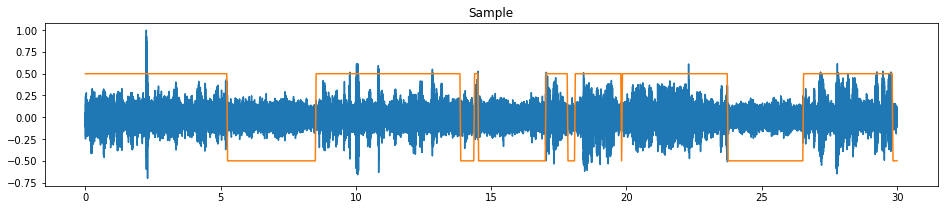

68 % voice 32 % silence


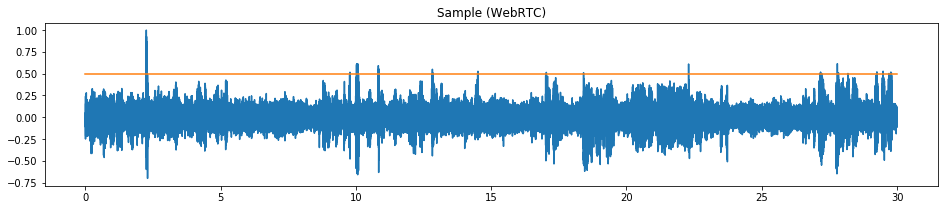

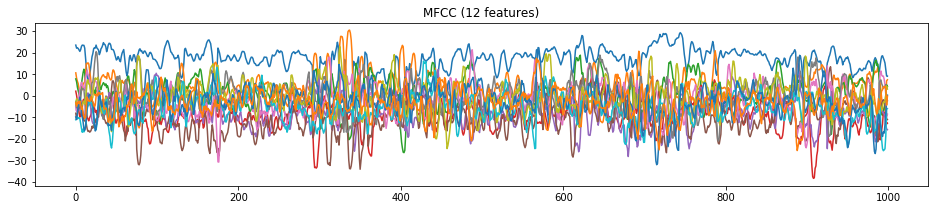

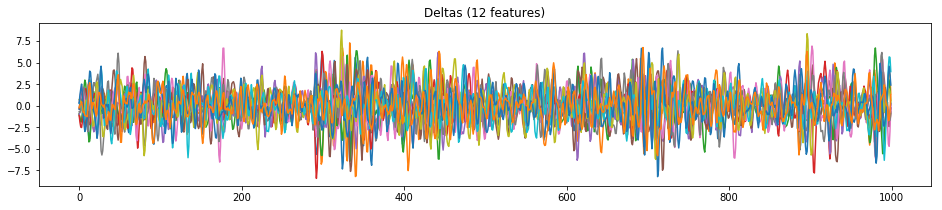

In [18]:
import matplotlib.pyplot as plt

class DataGenerator:
    
    def __init__(self, data, size_limit=0):        
        self.data = data
        self.size = size_limit if size_limit > 0 else len(data['labels'])
        self.data_mode = 0 # Default to training data
        
    def set_noise_level_db(self, level, reset_data_mode = True):
        
        if level not in noise_levels_db:
            raise Exception(f'Noise level "{level}" not supported! Options are: {list(noise_levels_db.keys())}')
        
        self.noise_level = level
        
        # Optionally reset data mode and position in file
        if reset_data_mode:
            if self.data_mode == 0:
                self.use_train_data()
            elif self.data_mode == 1:
                self.use_validate_data()
            elif self.data_mode == 2:
                self.use_test_data()
        
    def setup_generation(self, frame_count, step_size, batch_size, val_part=0.1, test_part=0.1):
        
        self.frame_count = frame_count
        self.step_size = step_size
        self.batch_size = batch_size
        
        # Setup indexes and sizes for data splits.
        self.train_index = 0
        self.val_index = int((1.0 - val_part - test_part) * self.size)
        self.test_index = int((1.0 - test_part) * self.size)
        
        self.train_size = self.val_index
        self.val_size = self.test_index - self.val_index
        self.test_size = self.size - self.test_index
        
    def use_train_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.train_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.train_index
        self.data_mode = 0
        
    def use_validate_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.val_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.val_index
        self.data_mode = 1
        
    def use_test_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.test_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.test_index
        self.data_mode = 2

    def get_data(self, index_from, index_to):
        frames = self.data['frames-' + self.noise_level][index_from : index_to]
        mfcc = self.data['mfcc-' + self.noise_level][index_from : index_to]
        delta = self.data['delta-' + self.noise_level][index_from : index_to]
        labels = self.data['labels'][index_from : index_to]
        return frames, mfcc, delta, labels
        
    def get_batch(self, index):
        
        # Get current position.
        pos = self.initial_pos + (self.batch_size * index) * self.step_size
        
        # Get all data needed.
        l = self.frame_count + self.step_size * self.batch_size
        frames, mfcc, delta, labels = self.get_data(pos, pos + l)
        
        x, y, i = [], [], 0
        
        # Get batches
        while len(y) < self.batch_size:
            
            # Get data for the window. 
            X = np.hstack((mfcc[i : i + self.frame_count], delta[i : i + self.frame_count]))
            
            # Append sequence to list of frames
            x.append(X)
            
            # Select label from center of sequence as label for that sequence.
            y_range = labels[i : i + self.frame_count]
            y.append(int(y_range[int(self.frame_count / 2)]))
            
            # Increment window using set step size
            i += self.step_size
        
        return x, y
        
    def plot_data(self, index_from, index_to, show_track=False):
        
        frames, mfcc, delta, labels = self.get_data(index_from, index_to)
        
        Vis.plot_sample(frames, labels)
        Vis.plot_sample_webrtc(frames)
        Vis.plot_features(mfcc, delta)
        
        # By returning a track and having this as the last statement in a code cell,
        # the track will appear as an audio track UI element (not supported by Windows).
        if show_track and OBJ_SHOW_PLAYABLE_TRACKS:
            return (AudioSegment(data=array.array('h', frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
        
# Test generator features.
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-3')
generator.use_train_data()
X, y = generator.get_batch(0)

print(f'Load a few frames into memory:\n{X[0]}\n\nCorresponding label: {y[0]}')

generator.plot_data(0, 1000)

# Hyper-parameters

The parameters below should be held constant for the remainder of the run.<br/>
It is suggested that `BATCH_SIZE` is kept relatively high for increased GPU utility.<br/>
`FRAMES` denotes the number of frames $\{f_{0}, f_{1}, \ldots ,f_{n}\}$ used to make a prediction for frame $f_{n}$.<br/>
`FEATURES` can be adjusted, but cannot exceed the number of features generated during data-set generation.<br/>
`STEP_SIZE` refers to the number of frames the sliding window is incremented each iteration. A small step size results in more training data, but logically increases training time as well.

In [9]:
BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6

# Baseline network

Before we implement the network, let's make a simple function that counts the number of model parameters.

In [10]:
def num_params(net, verbose = True):
    count = sum(p.numel() for p in net.parameters())
    if verbose:
        print(f'Model parameters: {count}')
    return count

Below is an implementation of a simple neural network to be used as a baseline for comparison.

Network consists of a single unidirectional LSTM recurrent layer and one or two fully connected layers after that, depending on the network size. The size of this network, as well as the following networks, is defined upon initalization using the `large` parameter. A small network has roughly $10.000$ parameters, while a large network has $30.000$ parameters.

In [11]:
import torch.nn as nn
from torch.nn import Linear, RNN, LSTM, GRU
import torch.nn.functional as F
from torch.nn.functional import softmax, relu
from torch.autograd import Variable

class Net(nn.Module):
    
    def __init__(self, large = True, lstm = True):
        super(Net, self).__init__()
    
        self.large = large
        self.lstm = lstm
        self.relu = nn.ReLU()
        
        if lstm:
            self.hidden = self.init_hidden()
            self.rnn = LSTM(input_size=FEATURES, hidden_size=FRAMES, num_layers=1, batch_first=True)
        else:
            self.rnn = GRU(input_size=FEATURES, hidden_size=FRAMES, num_layers=1, batch_first=True)
        
        if large:
            self.lin1 = nn.Linear(FRAMES**2, 26)
            self.lin2 = nn.Linear(26, 2)
        else:
            self.lin = nn.Linear(FRAMES**2, 2)
            
        self.softmax = nn.Softmax(dim=1)
    
    def init_hidden(self):
        h = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))
        c = Variable(torch.zeros(1, BATCH_SIZE, FRAMES))
        
        if OBJ_CUDA:
            h = h.cuda()
            c = c.cuda()
        
        return h, c
    
    def forward(self, x):
        #if OBJ_CUDA:
        #    self.rnn.flatten_parameters()
        
        # (batch, frames, features)
        if hasattr(self, 'lstm') and self.lstm:
            x, _ = self.rnn(x, self.hidden)
        else:
            x, _ = self.rnn(x)
            
        x = x.contiguous().view(-1, FRAMES**2)
        
        # (batch, units)
        if self.large:
            x = self.relu(self.lin1(x))
            x = self.lin2(x)
        else:
            x = self.lin(x)
        
        return self.softmax(x)

net = Net(large=False)
num_params(net)
print(net)

Model parameters: 8522
Net(
  (relu): ReLU()
  (rnn): LSTM(24, 30, batch_first=True)
  (lin): Linear(in_features=900, out_features=2, bias=True)
  (softmax): Softmax()
)


# Test network
This code snippet is a short test and demonstration of the flow of information in an untrained network (on the CPU). If everything goes right, no exception is thrown.

In [12]:
# Test generator
generator = DataGenerator(data)
generator.setup_generation(frame_count=FRAMES, step_size=STEP_SIZE, batch_size=BATCH_SIZE)
generator.use_train_data()
generator.set_noise_level_db('None')

print(generator.batch_count, 'training batches were found.')

def accuracy(out, y):
    '''
    Calculate accuracy of model where
    out.shape = (64, 2) and y.shape = (64)
    '''
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)

# Compact instantiation of untrained network on CPU
temp, OBJ_CUDA = OBJ_CUDA, False
net, OBJ_CUDA = Net(large=False), temp
del temp

# Run a few batches
for i in range(3):
    
    # Get batch
    X, y = generator.get_batch(i)
    X = torch.from_numpy(np.array(X)).float().cpu()
    y = torch.from_numpy(np.array(y)).cpu()

    # Run through network
    out = net(X)
    acc = accuracy(out, y).data.numpy()

print('Successfully ran the network!\n\nExample output:', out.data.numpy()[0])

570 training batches were found.
Successfully ran the network!

Example output: [ 0.45141679  0.54858315]


# Training

Defines a training session of a neural network using an instance of the `DataGenerator` to supply samples.

### Focal Loss

*Focal loss* (FL) is a variant of the popular Cross-Entropy (CE) loss function in which a factor $(1-p)^{\gamma}$ is added to the equation:

$FL(p_t) = -(1-p_t)^{\gamma}~\log(p_t)$

where $p_t$ is the probability of *ground truth class*. For $\gamma > 0$, the loss for well-classified samples is reduced, which in turn forces the optimizer to pay more attention to badly-classified samples. In the context of our study, FL serves to gradually decrease influence of easy samples (typically samples with little background noise) during training.

Focal loss was originally proposed by Tsung-Yi Lin et. al. as part of their paper on what came to be RetinaNet \[arXiv:1708.02002 \[cs.CV\]\].
The code below is a PyTorch implementation of the proposed Focal Loss and is courtesy of https://github.com/clcarwin/focal_loss_pytorch.

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### Training setup

`train_net` runs and monitors the training of a given network using data partitions defined in an instance of the `DataGenerator`.<br/>
Functions `save_net` and `load_net` are used to seamlessly save and load trained models from local storage.

In [14]:
import torch.optim as optim
from IPython.display import clear_output
import time

NOISE_LEVELS = ['None', '-15', '-3']

def net_path(epoch, title):
    part = os.getcwd() + '/models/' + title
    if epoch >= 0:
        return part + '_epoch' + str(epoch).zfill(3) + '.net'
    else:
        return part + '.net'

def save_net(net, epoch, title = 'net'):
    if not os.path.exists(os.getcwd() + '/models'):
        os.makedirs(os.getcwd() + '/models')
    torch.save(net, net_path(epoch, title))
    
def load_net(epoch = 14, title = 'net'):
    if OBJ_CUDA:
        return torch.load(net_path(epoch, title))
    else:
        return torch.load(net_path(epoch, title), map_location='cpu')

def train_net(net, data, size_limit = 0, noise_level = 'None', epochs = 15, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, use_focal_loss = True, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True):
    '''
    Full-featured training of a given neural network.
    A number of training parameters are optionally adjusted.
    If verbose is True, the training progress is continously
    plotted at the end of each epoch.
    If auto_save is True, the model will be saved every epoch.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.train_size == 0:
        print('Error: no training data was found!')
        return
    
    # Move network to GPU if available
    if OBJ_CUDA:
        net.cuda()
        
    # Instantiate the chosen loss function
    if use_focal_loss:
        criterion = FocalLoss(gamma)
        levels = NOISE_LEVELS
    else:
        criterion = nn.CrossEntropyLoss()
        levels = [noise_level]
    
    # Move criterion to GPU if available
    if OBJ_CUDA:
        criterion.cuda()
    
    # Instantiate the chosen optimizer with the parameters specified
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    # If verbose, print starting conditions
    if verbose:
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size*3 if use_focal_loss else generator.train_size
        _vlsz = generator.val_size*3 if use_focal_loss else generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        _critstr = f'Focal Loss (γ = {gamma})' if use_focal_loss else f'Cross-Entropy ({noise_level} dB)'
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Criterion: {_critstr}\nOptimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')
    
    net.train()
    stalecount, maxacc = 0, 0
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Continously plots the training/validation loss and accuracy
        of the model being trained. This functions is only called if
        verbose is True for the training session.
        '''
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        if generator.val_size != 0:
            plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        clear_output(wait=True)
        
    def run(net, optimize = False):
        '''
        This function constitutes a single epoch.
        Snippets are loaded into memory and their associated
        frames are loaded as generators. As training progresses
        and new frames are needed, they are generated by the iterator,
        and are thus not stored in memory when not used.
        If optimize is True, the associated optimizer will backpropagate
        and adjust network weights.
        Returns the average sample loss and accuracy for that epoch.
        '''
        epoch_loss, epoch_acc, level_acc = 0, [], []
        
        # In case we apply focal loss, we want to include all noise levels
        batches = generator.batch_count
        num_batches = batches*len(levels)
        
        if num_batches == 0:
            raise ValueError('Not enough data to create a full batch!')
        
        # Helper function responsible for running a batch
        def run_batch(X, y, epoch_loss, epoch_acc):

            X = Variable(torch.from_numpy(np.array(X)).float())
            y = Variable(torch.from_numpy(np.array(y))).long()

            if OBJ_CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)

            # Compute loss and accuracy for batch
            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # If training session, initiate backpropagation and optimization
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if OBJ_CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc
        
        # For each noise level scheduled
        for lvl in levels:
            
            # Set up generator for iteration
            generator.set_noise_level_db(lvl)
            
            # For each batch in noise level
            for i in range(batches):

                # Get a new batch and run it
                X, y = generator.get_batch(i)
                temp_loss, temp_acc = run_batch(X, y, epoch_loss, epoch_acc)
                epoch_loss += temp_loss / float(num_batches)
                level_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(level_acc)
    
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    # Iterate over training epochs
    for epoch in range(epochs):
        
        # Calculate loss and accuracy for that epoch and optimize
        generator.use_train_data()
        loss, acc = run(net, optimize=True)
        losses.append(loss)
        accs.append(acc)
        
        # If validation data is available, calculate validation metrics
        if generator.val_size != 0:
            net.eval()
            generator.use_validate_data()
            val_loss, val_acc = run(net)
            #print(val_loss, val_acc)
            #return
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            net.train()
            
            # Early stopping algorithm.
            # If validation accuracy does not improve for
            # a set amount of epochs, abort training and retrieve
            # the best model (according to validation accuracy)
            if epoch > 0 and val_accs[-1] <= maxacc:
                stalecount += 1
                if stalecount > patience and early_stopping:
                    return
            else:
                stalecount = 0
                maxacc = val_accs[-1]
        
        if auto_save:
            save_net(net, epoch, title)
        
        # Optionally plot performance metrics continously
        if verbose:
            
            # Print measured wall-time of first epoch
            if epoch == 0:
                dur = str(int((time.time() - start_time)/60))
                print(f'\nEpoch wall-time: {dur} min')
                
            plot(losses, accs, val_losses, val_accs)

### Set a seed

For reproducabillity purposes, a seed is set for `numpy` and `torch` using the `set_seed` function.

In [15]:
def set_seed(seed = 1337):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if OBJ_CUDA:
        torch.cuda.manual_seed_all(seed)

# Tools for performance evaluation

### Receiver Operating Characteristic
Below you will find a function `roc_auc` that serves to compute a ROC-curve for one or more trained networks. A ROC-curve is produced for each of the three noise levels and the Area Under Curve (AUC) is likely computed.

In [16]:
from sklearn import metrics

def test_predict(net, data, size_limit, noise_level):
    '''
    Computes predictions on test data using given network.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()

        if OBJ_CUDA:
            X = X.cuda()

        out = net(X)

        if OBJ_CUDA:
            out = out.cpu()
            y = y.cpu()

        # Add true labels.
        y_true.extend(y.data.numpy())

        # Add probabilities for positive labels.
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score
    


def roc_auc(nets, data, noise_lvl, size_limit = 0):
    '''
    Generates a ROC curve for the given network and data for each noise level.
    '''
    plt.figure(1, figsize=(16, 10))
    plt.title('Receiver Operating Characteristic (%s)' % noise_lvl, fontsize = 16)
    
    # For each noise level
    for key in nets:
        
        net = nets[key]
        
        # Make predictions
        y_true, y_score = test_predict(net, data, size_limit, noise_lvl)

        # Compute ROC metrics and AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        auc_res = metrics.auc(fpr, tpr)

        # Plots the ROC curve and show area.
        plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (key, auc_res))

    plt.xlim([0, 0.2])
    plt.ylim([0.6, 1])
    plt.ylabel('True Positive Rate', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right', prop={'size': 16})
    plt.show()

### FAR given fixed FRR
Below is a naïve implementation that computes the false acceptance rate (FAR) for a false rejection rate (FRR) below some given threshold (default is 2).<br/>
This is useful for comparison to similar studies.

In [17]:
from sklearn.metrics import confusion_matrix
import math

def far(net, data, size_limit = 0, frr = 1, plot = True):
    '''
    Computes the confusion matrix for a given network.
    '''
    
    # Evaluate predictions using threshold
    def apply_threshold(y_score, t = 0.5):
        return [1 if y >= t else 0 for idx, y in enumerate(y_score)]
    
    def fix_frr(y_true, y_score, frr_target, noise_level):
        
        # Quick hack for initial threshold level to hit 1% FRR a bit faster.
        if noise_level == 'None':
            t = 1e-4
        elif noise_level == '-15':
            t = 1e-5
        else:
            t = 1e-9
        
        # Compute FAR for a fixed FRR
        while t < 1.0:
            
            tn, fp, fn, tp = confusion_matrix(y_true, apply_threshold(y_score, t)).ravel()
            
            far = (fp * 100) / (fp + tn)
            frr = (fn * 100) / (fn + tp)
            
            if frr >= frr_target:
                return far, frr
            
            t *= 1.1
    
        # Return closest result if no good match found.
        return far, frr

    print('Network metrics:')

    # For each noise level
    for lvl in NOISE_LEVELS:
        
        # Make predictions
        y_true, y_score = test_predict(net, data, size_limit, lvl)
        print('FAR: %0.2f%% for fixed FRR at %0.2f%% and noise level' % fix_frr(y_true, y_score, frr, lvl), lvl)

### Authentic sequence labeling

`netvad` allows us to compare the developed model with its original labels and WebRTC for a given sample.
This qualitative test aims to simulate real-life scenarios in which a sequence is provided.

In [18]:
def netvad(net, data, noise_level = '-3', init_pos = 50, length = 700, only_plot_net = False, timeit = True):
    '''
    Generates a sample of specified length and runs it through
    the given network. By default, the network output is plotted
    alongside the original labels and WebRTC output for comparison.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    raw_frames, mfcc, delta, labels = generator.get_data(init_pos, init_pos+length)

    # Convert sample to list of frames
    def get_frames():
        i = 0
        while i < length-FRAMES:
            yield np.hstack((mfcc[i : i + FRAMES], delta[i : i + FRAMES]))
            i += 1
        
    # Start timer
    if timeit:
        start_net = time.time()
        
    # Creates batches from frames
    frames = list(get_frames())
    batches, i, num_frames = [], 0, -1
    while i < len(frames):
        full = i+BATCH_SIZE >= len(frames)
        end = i+BATCH_SIZE if not full else len(frames)
        window = frames[i:end]
        if full:
            num_frames = len(window)
            while len(window) < BATCH_SIZE:
                window.append(np.zeros((FRAMES, FEATURES)))
        batches.append(np.stack(window))
        i += BATCH_SIZE
        
    # Predict for each frame
    offset = 15
    accum_out = [0] * offset
    for batch in batches:
        X = Variable(torch.from_numpy(batch).float())
        if OBJ_CUDA:
            out = torch.max(net(X.cuda()), 1)[1].cpu().float().data.numpy()
        else:
            out = torch.max(net(X), 1)[1].float().data.numpy()
        accum_out.extend(out)
        
    # Stop timer
    if timeit:
        dur_net = str((time.time() - start_net)*1000).split('.')[0]
        device = 'GPU' if OBJ_CUDA else 'CPU'
        seq_dur = int((length/100)*3)
        print(f'Network processed {len(batches)*BATCH_SIZE} frames ({seq_dur}s) in {dur_net}ms on {device}.')

    # Adjust padding
    if num_frames > 0:
        accum_out = accum_out[:len(accum_out)-(BATCH_SIZE-num_frames)]
    accum_out = np.array(accum_out)
    
    frames = np.array(frames)
    
    # Cut frames outside of prediction boundary
    raw_frames = raw_frames[offset:-offset]
    labels = labels[offset:-offset]
    accum_out = accum_out[offset:]

    # Plot results
    print('Displaying results for noise level:', noise_level)
    if not only_plot_net:
        Vis.plot_sample(raw_frames, labels, show_distribution = False)
        Vis.plot_sample_webrtc(raw_frames, sensitivity = 0)
    Vis.plot_sample(raw_frames, accum_out, title = 'Sample (Neural Net)', show_distribution = False)

# Advanced architectures
This section contains implementations for the two advanced architectures that we have chosen to employ.<br/>
Please note that code to some extent contains functionality that is not addressed in the paper. They have been used during experimentation but all but the best results for each distinct architecture were finally omitted due to size constraints.

### Gated Conv + GRU recurrent layer

In [19]:
from torch.nn import Conv1d, Conv2d, Dropout, LSTM, GRU, BatchNorm1d, BatchNorm2d
import torch.nn.functional as F

class BiRNN(nn.Module):
    '''
    Bi-directional layer of gated recurrent units.
    Includes a fully connected layer to produce binary output.
    '''
    def __init__(self, num_in, num_hidden, batch_size = BATCH_SIZE, large = True, lstm = False, fcl = True, bidir = False):
        super(BiRNN, self).__init__()
        
        self.num_hidden, self.batch_size = num_hidden, batch_size
        self.lstm, self.bidir, self.layers = lstm, bidir, 2 if large else 1
        
        if lstm:
            self.hidden = self.init_hidden()
            self.rnn = LSTM(num_in, num_hidden, num_layers=self.layers, bidirectional=self.bidir, batch_first=True)
            sz = 18 if large else 16
        else:
            self.rnn = GRU(num_in, num_hidden, num_layers=self.layers, bidirectional=self.bidir, batch_first=True)
            sz = 18
            
        embed_sz = num_hidden*2 if self.bidir or self.layers > 1 else num_hidden
        
        if not fcl:
            self.embed = nn.Linear(embed_sz, 2)
        else:
            if large:
                self.embed = nn.Sequential(
                    nn.Linear(embed_sz, sz+14),
                    nn.BatchNorm1d(sz+14),
                    nn.Dropout(p=0.2),
                    nn.ReLU(),
                    nn.Linear(sz+14, sz),
                    nn.BatchNorm1d(sz),
                    nn.Dropout(p=0.2),
                    nn.ReLU(),
                    nn.Linear(sz, 2)
                    )
            else:
                self.embed = nn.Sequential(
                    nn.Linear(embed_sz, sz),
                    nn.BatchNorm1d(sz),
                    nn.Dropout(p=0.2),
                    nn.ReLU(),
                    nn.Linear(sz, 2)
                    )
                            
    def init_hidden(self):
        num_dir = 2 if self.bidir or self.layers > 1 else 1
        h = Variable(torch.zeros(num_dir, self.batch_size, self.num_hidden))
        c = Variable(torch.zeros(num_dir, self.batch_size, self.num_hidden))
        
        if OBJ_CUDA:
            h = h.cuda()
            c = c.cuda()
        
        return h, c
        
    def forward(self, x):
        if OBJ_CUDA:
            self.rnn.flatten_parameters()
        
        x = x.permute(0, 2, 1)
        
        if self.lstm:
            x, self.hidden = self.rnn(x, self.hidden)
        else:
            x, self.hidden = self.rnn(x)
            
        # Extract outputs from forward and backward sequence and concatenate
        # If not bidirectional, only use last output from forward sequence
        x = self.hidden.view(self.batch_size, -1)
        
        # (batch, features)
        return self.embed(x)
    
    
class GatedConv(nn.Module):
    '''
    Gated convolutional layer using tanh as activation and a sigmoidal gate.
    The convolution is padded to keep its original dimensions.
    '''
    def __init__(self, in_channels, out_channels, kernel_size = 3, dilation = 1, padding = True):
        super(GatedConv, self).__init__()
        
        padding = int((kernel_size-1)/2) if padding else 0
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )
        self.conv_gate = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.conv(x) * self.conv_gate(x)
    

class Conv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size = 3, dilation = 1, padding = True):
        super(Conv, self).__init__()
        
        padding = int((kernel_size-1)/2) if padding else 0
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.conv(x)
    
     
class GatedResidualConv(nn.Module):
    '''
    Legacy class.
    Gated residual convolutional layer using tanh as activation and a sigmoidal gate.
    Outputs the accumulated input to be used in the following layer, as well as a
    residual connection that is added to the output of the following layer using
    element-wise multiplication. Input and output sizes are unchanged.
    '''
    def __init__(self, channels, kernel_size = 3, dilation = 1):
        super(GatedResidualConv, self).__init__()
        
        self.gated_conv = GatedConv(channels, channels)
        
    def forward(self, x, r = None):
        # Residual connection defaults to x
        if r is None:
            r = x
        out = self.gated_conv(x)
        
        # (acummulated input, residual connection)
        return out * x, out * r
    

class NickNet(nn.Module):
    '''
    This network consists of (gated) convolutional layers,
    followed by a bi-directional recurrent layer and one or
    more fully connected layers. Output is run through a
    softmax function.
    '''
    def __init__(self, large = True, residual_connections = False, gated = True, lstm = False,
                 fcl = True, bidir = False, frames = FRAMES, features = FEATURES):
        
        super(NickNet, self).__init__()
        
        self.large = large
        self.residual_connections = residual_connections
        
        # Define number of channels depending on configuration.
        # This is done to ensure that number of parameters are
        # held some-what constant for all model configurations.
        if large:
            if gated:
                conv_channels1, conv_channels2, conv_channels3, conv_channels4 = 32, 28, 25, 18
            else:
                conv_channels1, conv_channels2, conv_channels3, conv_channels4 = 38, 35, 31, 24
            conv_channels_out = conv_channels4
        else:
            if gated:
                conv_channels1, conv_channels2, conv_channels3 = 20, 18, 16
            else:
                conv_channels1, conv_channels2, conv_channels3 = 26, 20, 16
            conv_channels_out = conv_channels3

        # Gated convolution with residual connections
        if residual_connections:
            conv_channels3 = conv_channels2
            self.conv1 = GatedConv(features, conv_channels3)
            self.conv2 = GatedResidualConv(conv_channels3)
            self.conv3 = GatedResidualConv(conv_channels3)
            if large:
                self.conv4 = GatedResidualConv(conv_channels3)

        # Gated convolution
        elif gated:
            self.conv1 = GatedConv(features, conv_channels1)
            self.conv2 = GatedConv(conv_channels1, conv_channels2)
            self.conv3 = GatedConv(conv_channels2, conv_channels3)
            if large:
                self.conv4 = GatedConv(conv_channels3, conv_channels4)

        # Default convolution
        else:
            self.conv1 = Conv(features, conv_channels1)
            self.conv2 = Conv(conv_channels1, conv_channels2)
            self.conv3 = Conv(conv_channels2, conv_channels3)
            if large:
                self.conv4 = Conv(conv_channels3, conv_channels4)
        
        # Recurrent layer
        num_hidden = conv_channels_out + 11 if large else conv_channels_out + 5
        self.rnn = BiRNN(conv_channels_out, num_hidden, large=large, lstm=lstm, fcl=fcl, bidir=bidir)
        
    def forward(self, x):
        # (batch, frames, features)
        x = x.permute(0, 2, 1)
        
        # (batch, features/channels, frames)
        x = self.conv1(x)
        
        if self.residual_connections:
            x,r = self.conv2(x)
            x,r = self.conv3(x, r)
            if self.large:
                x,r = self.conv4(x, r)
            x = x * r 
        else:
            x = self.conv2(x)
            x = self.conv3(x)
            if self.large:
                x = self.conv4(x)
        
        #   (batch, channels, frames)
        # ->(batch, frames, channels)
        x = self.rnn(x)
        
        # (batch, 2)
        return F.softmax(x, dim=1)

gru = NickNet(large=True)
num_params(gru)
print(gru)

Model parameters: 29605
NickNet(
  (conv1): GatedConv(
    (conv): Sequential(
      (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (conv_gate): Sequential(
      (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sigmoid()
    )
  )
  (conv2): GatedConv(
    (conv): Sequential(
      (0): Conv1d(32, 28, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (conv_gate): Sequential(
      (0): Conv1d(32, 28, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sigmoid()
    )
  )
  (conv3): GatedConv(
    (conv): Sequential(
      (0): Co

### DenseNet

In [20]:
class DenseSingle(nn.Module):

    def __init__(self, input_size, output_size, dropout, dilation, padding, kernel_size, stride):
        super(DenseSingle, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=padding, 
                      stride=stride, dilation=dilation, bias=False),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        out = self.layer(x)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    
    def __init__(self, input_size, n_layers, growth_rate, dropout, dilation, padding, kernel_size, stride):
        super(DenseBlock, self).__init__()
        
        layers = []
        for i in range(n_layers):
            layers.append(DenseSingle(input_size + i * growth_rate, growth_rate, 
                                      dropout, dilation, padding, kernel_size, stride))
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):        
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(TransitionBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv1d(input_size, output_size, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(output_size),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):        
        return self.layers(x)
    
class DenseNet(nn.Module):
    def __init__(self, large=False):
        super(DenseNet, self).__init__()

        if large:
            
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=48, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(48),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=80, output_size=48, dropout=dropout)

            self.dense2 = DenseBlock(input_size=48, n_layers=8, growth_rate=4, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=80, out_channels=80, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(80),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(80, 2, bias=False)

            
        else:
        
            dropout = 0.4
        
            self.cnn_in = nn.Sequential(
                nn.Conv1d(in_channels=24, out_channels=24, kernel_size=6, stride=1, padding=0, 
                          dilation=4, bias=False),
                nn.BatchNorm1d(24),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.dense1 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.trans1 = TransitionBlock(input_size=42, output_size=24, dropout=dropout)

            self.dense2 = DenseBlock(input_size=24, n_layers=6, growth_rate=3, kernel_size=3,
                                     dilation=1, padding=1, stride=1, dropout=dropout)

            self.cnn_out = nn.Sequential(
                nn.Conv1d(in_channels=42, out_channels=42, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(42),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout)
            )

            self.out = nn.Linear(42, 2, bias=False)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        
        x = self.cnn_in(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.cnn_out(x)
        
        x = x.view(BATCH_SIZE, -1)
     
        return F.softmax(self.out(x), dim=1)

set_seed()
densenet = DenseNet(large=True)
num_params(densenet)
print(densenet)

Model parameters: 29696
DenseNet(
  (cnn_in): Sequential(
    (0): Conv1d(24, 48, kernel_size=(6,), stride=(1,), dilation=(4,), bias=False)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.4)
  )
  (dense1): DenseBlock(
    (block): Sequential(
      (0): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(48, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Dropout(p=0.4)
        )
      )
      (1): DenseSingle(
        (layer): Sequential(
          (0): Conv1d(52, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

# Training & Results

If `OBJ_TRAIN_MODELS` is enabled, training loops are run for each of our defined models. This is a resource-intensive task and takes approximately 30 minutes for each small model and 90 minutes for each large model when run on a GPU-enabled machine using a Nvidia GTX1080.<br/>
When running a new training loop using `train_net`, we first need to instantiate a neural network. Calling `train_net` with our defined network as parameter initiates a GPU-accelerated (if available) training session. If everything succeeds, a recap of initial training parameters is first shown, followed by figures monitoring the training progress as it progresses.

If `OBJ_TRAIN_MODELS` is disabled, all relevant models are loaded into memory from local storage (they should easily fit in memory) and their respective metrics should be displayed as if they had just been trained.


ROC Curves:


C:\Users\nickl\AppData\Local\Continuum\anaconda3\envs\dp\lib\site-packages\ipykernel_launcher.py:48: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


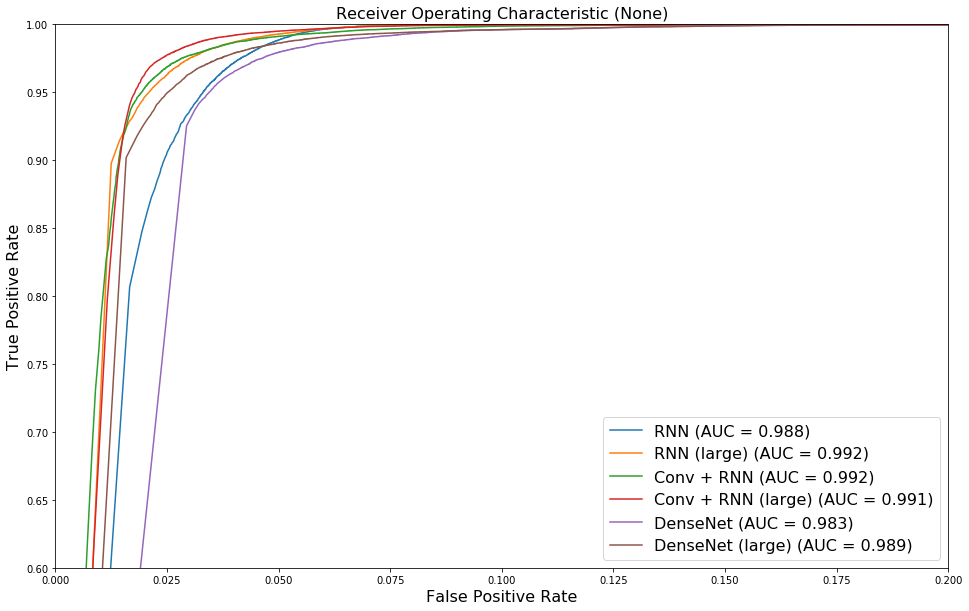

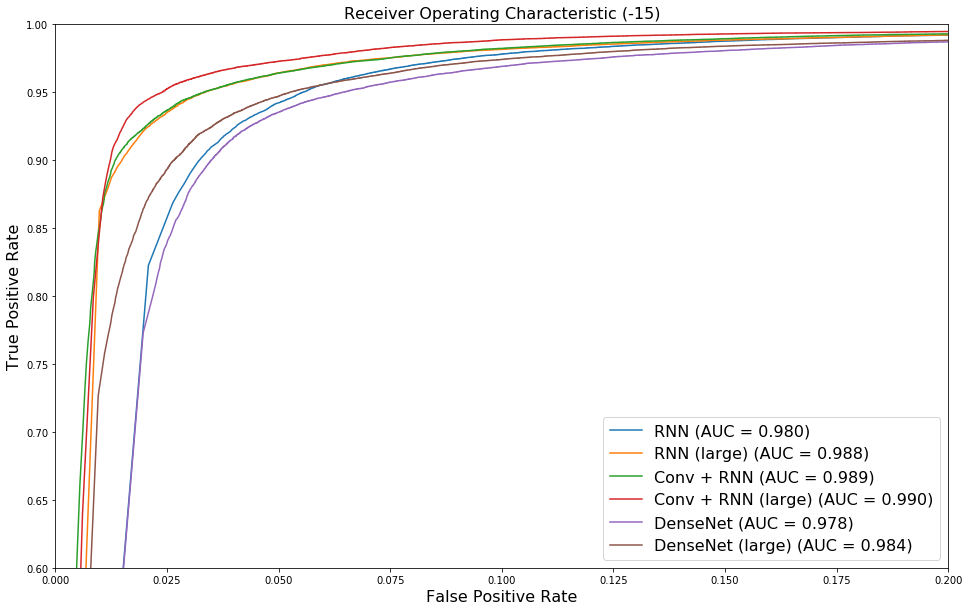

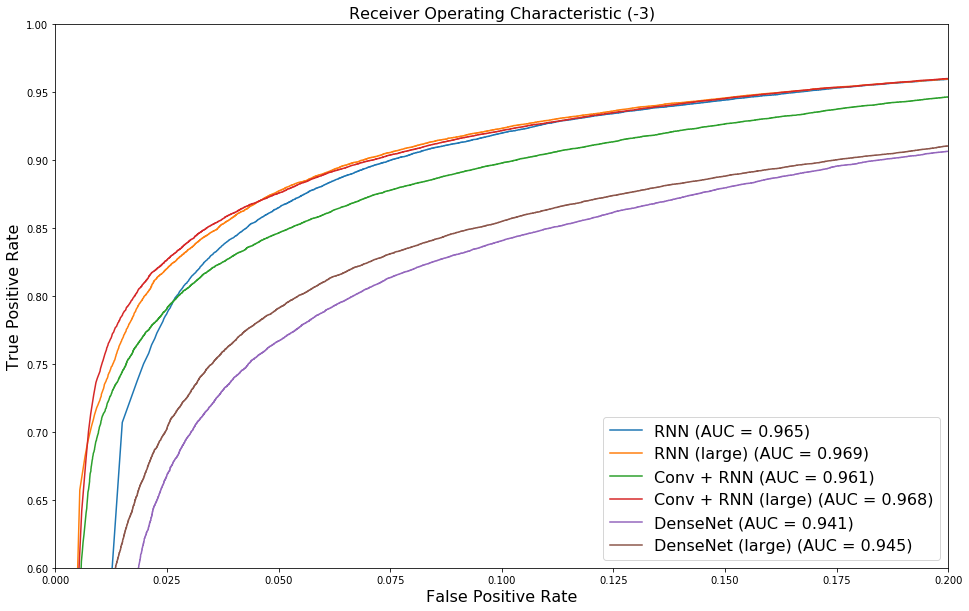


Fixed FRR:

net:
Network metrics:
FAR: 5.11% for fixed FRR at 1.04% and noise level None
FAR: 17.18% for fixed FRR at 1.01% and noise level -15
FAR: 48.13% for fixed FRR at 1.00% and noise level -3

net_large:
Network metrics:
FAR: 4.34% for fixed FRR at 1.07% and noise level None
FAR: 16.84% for fixed FRR at 1.02% and noise level -15
FAR: 51.75% for fixed FRR at 1.03% and noise level -3

gru:
Network metrics:
FAR: 4.71% for fixed FRR at 1.01% and noise level None
FAR: 15.58% for fixed FRR at 1.01% and noise level -15
FAR: 63.10% for fixed FRR at 1.08% and noise level -3

gru_large:
Network metrics:
FAR: 3.61% for fixed FRR at 1.00% and noise level None
FAR: 11.14% for fixed FRR at 1.01% and noise level -15
FAR: 58.99% for fixed FRR at 1.01% and noise level -3

densenet:
Network metrics:
FAR: 6.86% for fixed FRR at 1.03% and noise level None
FAR: 24.45% for fixed FRR at 1.00% and noise level -15
FAR: 58.14% for fixed FRR at 1.07% and noise level -3

densenet_large:
Network metrics:
FA

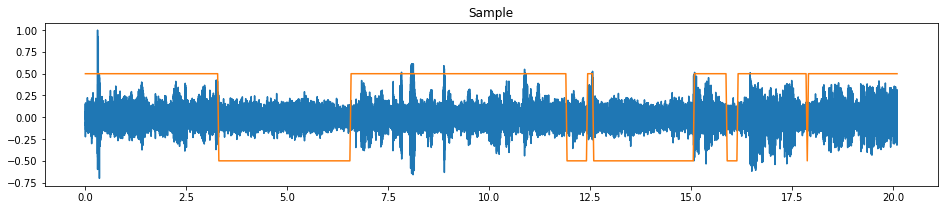

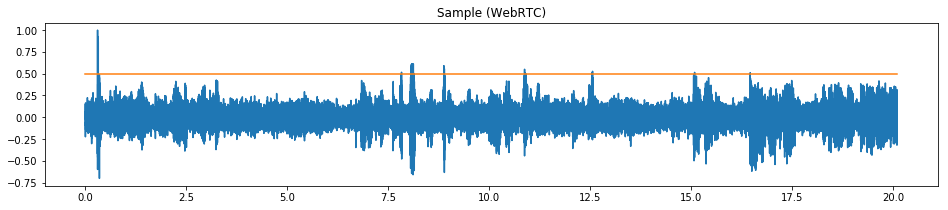

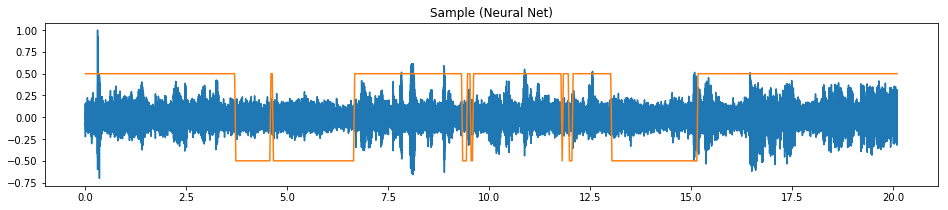


net_large:
Network processed 2048 frames (21s) in 21ms on GPU.
Displaying results for noise level: -3


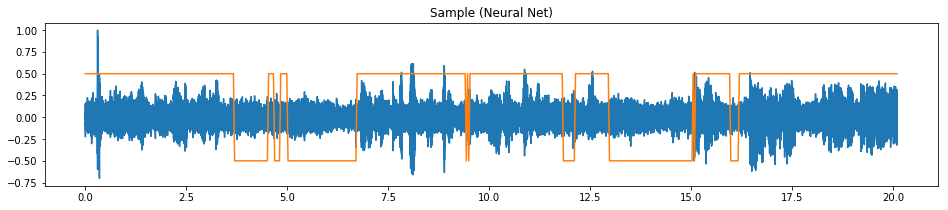


gru:
Network processed 2048 frames (21s) in 25ms on GPU.
Displaying results for noise level: -3


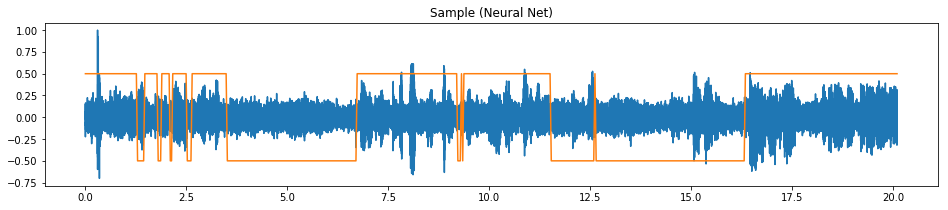


gru_large:
Network processed 2048 frames (21s) in 28ms on GPU.
Displaying results for noise level: -3


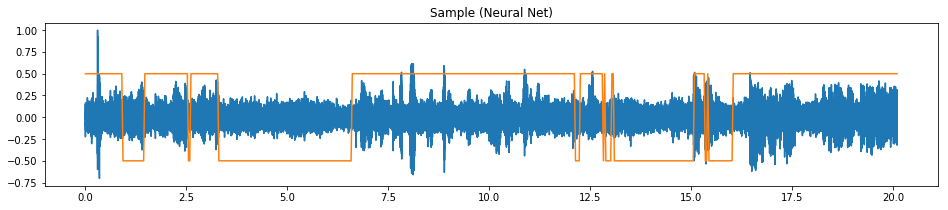


densenet:
Network processed 2048 frames (21s) in 27ms on GPU.
Displaying results for noise level: -3


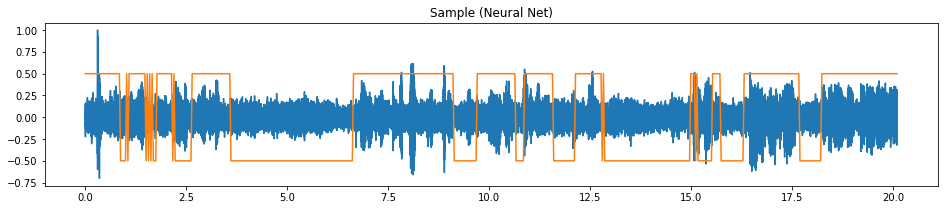


densenet_large:
Network processed 2048 frames (21s) in 30ms on GPU.
Displaying results for noise level: -3


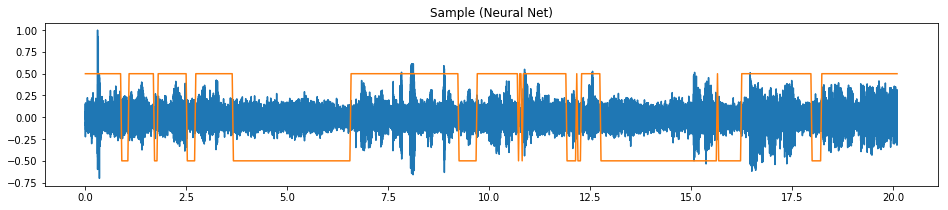

In [23]:
if OBJ_TRAIN_MODELS:
    
    # LSTM, small, γ = 0
    set_seed()
    net = Net(large=False)
    train_net(net, data, title='net', gamma=0)
    
    # LSTM, large, γ = 2
    set_seed()
    net_large = Net()
    train_net(net_large, data, title='net_large', gamma=2)
    
    # Conv + GRU, small, γ = 2
    set_seed()
    gru = NickNet(large=False)
    train_net(gru, data, title='gru', gamma=2)
    
    # Conv + GRU, large, γ = 2
    set_seed()
    gru_large = NickNet()
    train_net(gru_large, data, title='gru_large', gamma=2)
    
    # DenseNet, small, γ = 2
    set_seed()
    densenet = DenseNet(large=False)
    train_net(densenet, data, title='densenet', use_adam=False, lr=1, momentum=0.7, gamma=2)
    
    # DenseNet, large, γ = 2
    set_seed()
    densenet_large = DenseNet(large=True)
    train_net(densenet, data, title='densenet_large', use_adam=False, lr=1, momentum=0.7, gamma=2)
    
else:
    
    net = load_net(title='net')
    net_large = load_net(title='net_large')
    gru = load_net(title='gru')
    gru_large = load_net(title='gru_large')
    densenet = load_net(title='densenet', epoch=12)
    densenet_large = load_net(title='densenet_large')

# ROC Curve
print('\nROC Curves:')

roc_auc({
    'RNN': net,
    'RNN (large)': net_large,
    'Conv + RNN': gru,
    'Conv + RNN (large)': gru_large,
    'DenseNet': densenet,
    'DenseNet (large)': densenet_large
}, data, 'None')

roc_auc({
    'RNN': net,
    'RNN (large)': net_large,
    'Conv + RNN': gru,
    'Conv + RNN (large)': gru_large,
    'DenseNet': densenet,
    'DenseNet (large)': densenet_large
}, data, '-15')

roc_auc({
    'RNN': net,
    'RNN (large)': net_large,
    'Conv + RNN': gru,
    'Conv + RNN (large)': gru_large,
    'DenseNet': densenet,
    'DenseNet (large)': densenet_large
}, data, '-3')

# Fixed FRR
print('\nFixed FRR:')

print('\nnet:')
far(net, data, frr=1)

print('\nnet_large:')
far(net_large, data, frr=1)

print('\ngru:')
far(gru, data, frr=1)

print('\ngru_large:')
far(gru_large, data, frr=1)

print('\ndensenet:')
far(densenet, data, frr=1)

print('\ndensenet_large:')
far(densenet_large, data, frr=1)

# Qualitative results
print('\nQualitative results:')

print('\nnet:')
netvad(net, data, only_plot_net=False)

print('\nnet_large:')
netvad(net_large, data, only_plot_net=True)

print('\ngru:')
netvad(gru, data, only_plot_net=True)

print('\ngru_large:')
netvad(gru_large, data, only_plot_net=True)

print('\ndensenet:')
netvad(densenet, data, only_plot_net=True)

print('\ndensenet_large:')
netvad(densenet_large, data, only_plot_net=True)

# WebRTC VAD accuracy

While we cannot produce curves for the WebRTC due to it being an API, we can measure its accuracy on a number of different noise levels and sensitivities. From qualitative analysis it is evident that it classifies almost all samples as pure speech on the high noise level (-3 dB), which is reflected in its near-50% accuracy across all sensitivity levels.

In [137]:
def webrtc_vad_accuracy(data, sensitivity, noise_level):

    vad = webrtcvad.Vad(sensitivity)    
    generator = DataGenerator(data, size_limit=0)
    
    # Not needed but must be set.
    generator.setup_generation(frame_count=1, step_size=1, batch_size=1)
    
    # Setup noise level and test data.
    generator.set_noise_level_db(noise_level)
    generator.use_test_data()
    
    correct = 0
    batch_size = 1000
    
    for pos in range(0, generator.size, batch_size):
        
        frames, _, _, labels = generator.get_data(pos, pos + batch_size)
        
        for i, frame in enumerate(frames):
            if vad.is_speech(frame.tobytes(), sample_rate=SAMPLE_RATE) == labels[i]:
                correct += 1

    return (correct / generator.size)

print('Accuracy (sensitivity 0, no noise):', webrtc_vad_accuracy(data, 0, 'None'))
print('Accuracy (sensitivity 0, -15 dB noise level):', webrtc_vad_accuracy(data, 0, '-15'))
print('Accuracy (sensitivity 0, -3 dB noise level):', webrtc_vad_accuracy(data, 0, '-3'))

print('Accuracy (sensitivity 1, no noise):', webrtc_vad_accuracy(data, 1, 'None'))
print('Accuracy (sensitivity 1, -15 dB noise level):', webrtc_vad_accuracy(data, 1, '-15'))
print('Accuracy (sensitivity 1, -3 dB noise level):', webrtc_vad_accuracy(data, 1, '-3'))

print('Accuracy (sensitivity 2, no noise):', webrtc_vad_accuracy(data, 2, 'None'))
print('Accuracy (sensitivity 2, -15 dB noise level):', webrtc_vad_accuracy(data, 2, '-15'))
print('Accuracy (sensitivity 2, -3 dB noise level):', webrtc_vad_accuracy(data, 2, '-3'))

Accuracy (sensitivity 0, no noise): 0.9436121083871345
Accuracy (sensitivity 0, -15 dB noise level): 0.8215120734076335
Accuracy (sensitivity 0, -3 dB noise level): 0.5250904854844204
Accuracy (sensitivity 1, no noise): 0.9461225497224929
Accuracy (sensitivity 1, -15 dB noise level): 0.8472395876620085
Accuracy (sensitivity 1, -3 dB noise level): 0.5454354491212656
Accuracy (sensitivity 2, no noise): 0.9530330560850175
Accuracy (sensitivity 2, -15 dB noise level): 0.851721964112676
Accuracy (sensitivity 2, -3 dB noise level): 0.5552429522698773
